In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install keras
!pip install tensorflow
!pip install rasa==1.1.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.2/447.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.2/516.2 kB 19.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of rasa to determine which version is compatible with other requirements. This could take a while.
ERROR: Ignored the following versions that require a different python version:

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
import os
import cv2
import numpy as np
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/koryakinp/fingers")

Skipping, found downloaded files in "./fingers" (use force=True to force download)


In [7]:
dataset_dir = '/content/fingers/test'

images = []
labels = []

for filename in os.listdir(dataset_dir):
    image = cv2.imread(os.path.join(dataset_dir, filename), cv2.IMREAD_GRAYSCALE)    
    image = cv2.resize(image, (64, 64,))

    images.append(image)
    
    # Getting the label from the filename (the first character)
    label = int(filename[-6])
    
    # Appending the label to the labels list
    labels.append(label)

# Convert the lists to NumPy arrays
x_test = np.array(images)
y_test = np.array(labels)


In [8]:
dataset_dir = '/content/fingers/train'

images = []
labels = []

# Iterate through each image file
for filename in os.listdir(dataset_dir):
    image = cv2.imread(os.path.join(dataset_dir, filename), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (64, 64,))
    
    # Appending the image to the images list
    images.append(image)
    
    # Get the label from the filename (the first character)
    label = int(filename[-6])
    
    # Append the label to the labels list
    labels.append(label)

# Convert the lists to NumPy arrays
x_train = np.array(images)
y_train = np.array(labels)

In [9]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [10]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_test = to_categorical(y_test, num_classes=6)

In [11]:
print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))

Y_train shape: (18000, 6)
Y_test shape: (3600, 6)


In [12]:
def convolutional_model(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(filters= 8. , kernel_size=4 , padding='same',strides=1)(input_img)
    ## RELU
    A1 = tfl.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool2D(pool_size=8, strides=8, padding='SAME')(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(filters= 16. , kernel_size=2 , padding='same',strides=1)(P1)
    ## RELU
    A2 =  tfl.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool2D(pool_size=4, strides=4, padding='SAME')(A2)
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tfl.Dense(units= 6 , activation='softmax')(F)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [13]:
conv_model = convolutional_model((64, 64,1))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         136       
                                                                 
 re_lu (ReLU)                (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 16)          0         
                                                             

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train[0:1800,], Y_train[0:1800,]))
train_dataset = train_dataset.batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test[0:300,], Y_test[0:300,]))
test_dataset = test_dataset.batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
29/29 [==============================] - 4s 108ms/step - loss: 36.6108 - accuracy: 0.1972 - val_loss: 10.0601 - val_accuracy: 0.2700
Epoch 2/100
29/29 [==============================] - 4s 149ms/step - loss: 6.1084 - accuracy: 0.2283 - val_loss: 4.8016 - val_accuracy: 0.3067
Epoch 3/100
29/29 [==============================] - 3s 101ms/step - loss: 3.9348 - accuracy: 0.3444 - val_loss: 3.5907 - val_accuracy: 0.3867
Epoch 4/100
29/29 [==============================] - 3s 101ms/step - loss: 3.0319 - accuracy: 0.4317 - val_loss: 2.8295 - val_accuracy: 0.4600
Epoch 5/100
29/29 [==============================] - 4s 152ms/step - loss: 2.4205 - accuracy: 0.4978 - val_loss: 2.2891 - val_accuracy: 0.4967
Epoch 6/100
29/29 [==============================] - 3s 96ms/step - loss: 1.9757 - accuracy: 0.5611 - val_loss: 1.9265 - val_accuracy: 0.5500
Epoch 7/100
29/29 [==============================] - 3s 100ms/step - loss: 1.6550 - accuracy: 0.6000 - val_loss: 1.6636 - val_accuracy: 0.590

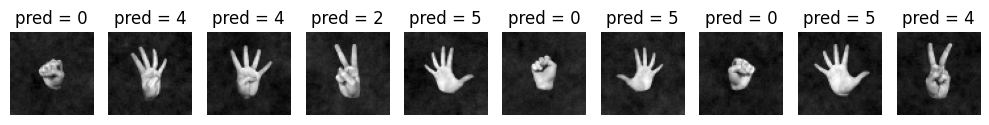

In [15]:
import random
import cv2
from matplotlib import pyplot as plt

numbers = list(range(1, 1001))
random_array = random.sample(numbers, 10)

fig = plt.figure(figsize=(10, 7))

for i, idx in enumerate(random_array):
    img_resized = cv2.resize(x_test[idx], (64, 64))
    y_pred = np.argmax(conv_model.predict(np.expand_dims(x_test[idx], axis=0),verbose=0))
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(img_resized, cmap='gray')
    ax.axis('off')
    ax.set_title("pred = " + str(y_pred))

plt.tight_layout()
plt.show()
